In [107]:
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.style.use('seaborn-darkgrid')
plt.rc('figure', figsize=(16,10))
plt.rc('lines', markersize=4)

import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### Get a sample stock price from 2019-01-01 to today

In [108]:
# Get the data of the Apple stock (code AAPL)
data = yf.download('AAPL','2019-01-01','2020-04-30')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,158.529999,159.360001,156.479996,157.740005,154.618546,35003500
2019-01-02,154.889999,158.850006,154.229996,157.919998,154.794983,37039700
2019-01-03,143.979996,145.720001,142.000000,142.190002,139.376251,91312200
2019-01-04,144.529999,148.550003,143.800003,148.259995,145.326126,58607100
2019-01-07,148.699997,148.830002,145.899994,147.929993,145.002686,54777800


### Extract the Close price column to plot

In [109]:
df = pd.DataFrame(data, columns=['Close'])
df = df.reset_index()
df.isna().values.any() # check for NaN

False

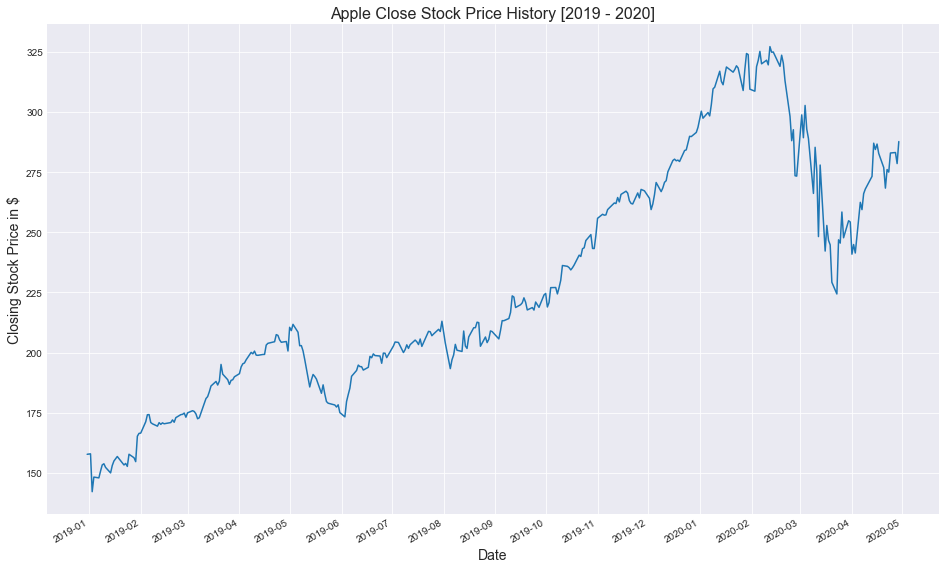

In [110]:
# Import matplotlib package for date plots

months = mdates.MonthLocator() # Get every year
dateFmt = mdates.DateFormatter('%Y-%m') # Set year format

# Create subplots to plot graph and control axes
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Close'])

# Format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)

# Set figure title
plt.title('Apple Close Stock Price History [2019 - 2020]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

### Get stock of Apple, Google, Microsoft, Amazon, Facebook via Yahoo Finance

In [111]:
def get_close_stock_price(codes, start_date='2019-01-01', end_date='2020-04-30'):
    data = { code : yf.download(code, start_date, end_date) for code in codes }
    data = { key : pd.DataFrame(value, columns=['Close']).rename(columns={'Close': f'{key}'}) for key, value in data.items() }
    df = None
    for key, value in data.items():
        if df is None:
            df = value
        else:
            df = df.merge(value, left_index=True, right_index=True)
    return df

df = get_close_stock_price(['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'FB'])
df.to_csv('data/close_price_big_5.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [112]:
df = pd.read_csv('data/close_price_big_5.csv', index_col=['Date'], infer_datetime_format=True, parse_dates=['Date'])

df = np.log(df)
df.tail(10)

,AAPL,GOOGL,MSFT,AMZN,FB
Date,,,,,
2020-04-16,5.658402,7.136825,5.176376,7.786631,5.171903
2020-04-17,5.644740,7.153834,5.185149,7.772753,5.188726
2020-04-20,5.623765,7.139779,5.165129,7.780558,5.183131
2020-04-21,5.592367,7.100159,5.122892,7.752816,5.140493
2020-04-22,5.620763,7.137604,5.156293,7.767895,5.205544
2020-04-23,5.616880,7.147693,5.144117,7.782995,5.221058
2020-04-24,5.645341,7.151956,5.162211,7.787473,5.247392
2020-04-27,5.646047,7.147449,5.159343,7.773174,5.233779
2020-04-28,5.629705,7.116873,5.134680,7.746768,5.208994


In [113]:
df.index

DatetimeIndex(['2018-12-31', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10',
               '2019-01-11', '2019-01-14',
               ...
               '2020-04-16', '2020-04-17', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-27',
               '2020-04-28', '2020-04-29'],
              dtype='datetime64[ns]', name='Date', length=335, freq=None)

In [114]:
df_plot = df.reset_index().melt('Date', var_name='cols',  value_name='vals')
df_plot.isna().values.any()

False

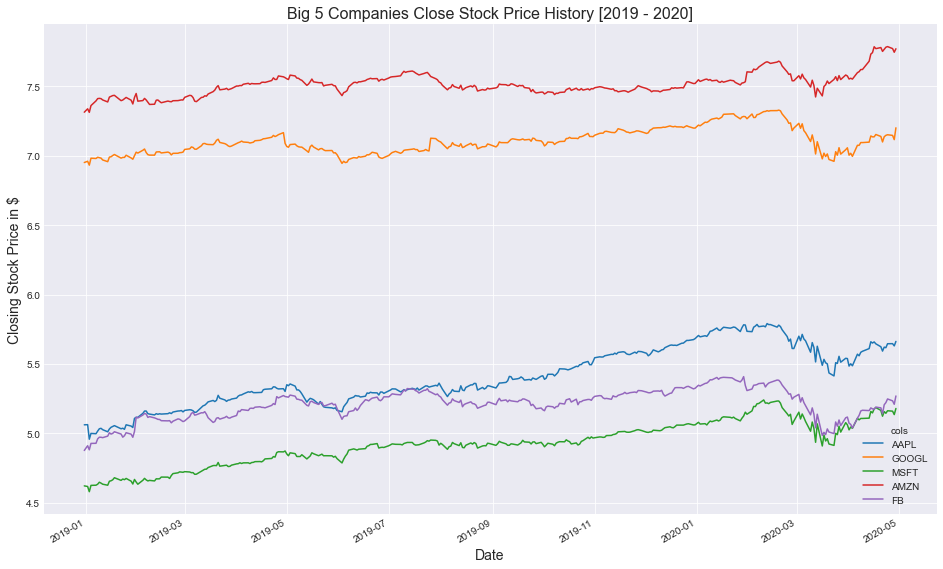

In [115]:
# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="Date", y="vals", hue='cols', data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Big 5 Companies Close Stock Price History [2019 - 2020]', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

### Create X, y matrices for regression
Use history = number of days before prediction date

In [116]:
def create_Xy(df, history=1):
    '''df has index as date
    columns are stock price of the companies
    '''
    X, y, dates = [], [], []
    for row_idx in range(history, len(df)):
        y.append( df.iloc[row_idx,:].values.reshape(-1) )
        X.append( df.iloc[row_idx-history:row_idx,:].values.reshape(-1) )
        dates.append(df.index[row_idx])
    X, y = np.array(X), np.array(y)
    return X, y, dates

X,y,dates = create_Xy(df, history=5)
# use 7/10 of the dataset to train (use past price to predict future price)
n_train = len(y) * 7 // 10
X_train, y_train, dates_train, X_test, y_test, dates_test = X[:n_train], y[:n_train], dates[:n_train], X[n_train:], y[n_train:], dates[n_train:]

### Create a Linear Regression Model to predict stock price

In [117]:
clf = LinearRegression()
clf.fit(X_train, y_train)
ypred = clf.predict(X_test)

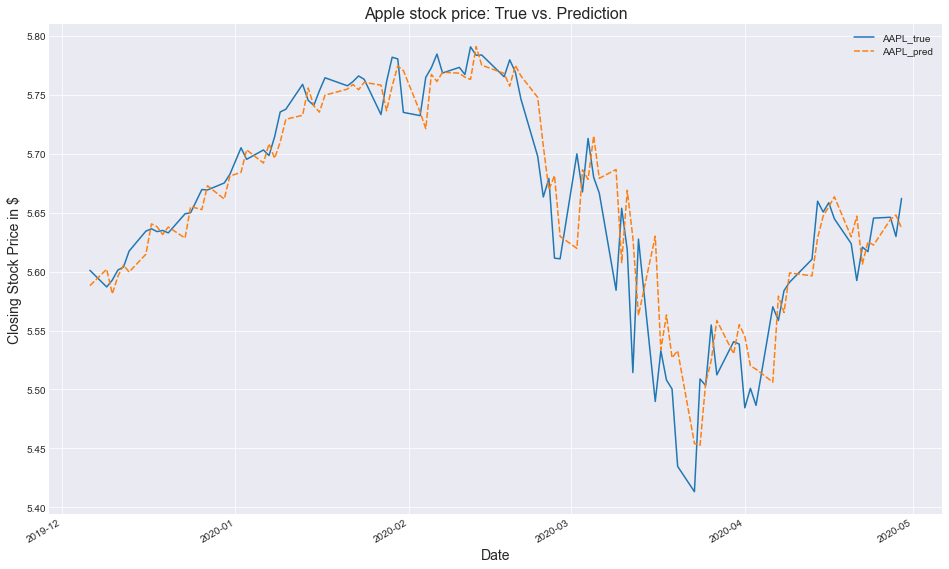

Apple, Google, Microsoft, Amazon, Facebook stocks accuracy: 
85.43242671165876
88.4833596011881
74.33851977085068
90.91972193316873
84.51592056882541
Average: 
84.73798971713833 %


In [118]:
df_plot = pd.DataFrame({"AAPL_true": y_test[:,0], 'AAPL_pred': ypred[:,0]}, index=dates_test)

# Create subplots to plot graph and control axes
fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(data=df_plot)

# Format the ticks
loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

# Set figure title
plt.title('Apple stock price: True vs. Prediction', fontsize=16)
# Set x label
plt.xlabel('Date', fontsize=14)
# Set y label
plt.ylabel('Closing Stock Price in $', fontsize=14)

# Rotate and align the x labels
fig.autofmt_xdate()

# Show plot
plt.show()

sum=0
print('Apple, Google, Microsoft, Amazon, Facebook stocks accuracy: ')
for i in range(5): 
    print(r2_score(y_test[:,i], ypred[:,i]) * 100)
    sum += r2_score(y_test[:,i], ypred[:,i])

print('Average: ')
print(sum / 5 * 100, "%")

# Exercise
1. Play with the above code to get familiar with stock price data and ways to create training data ( X = past stock price, y = future stock price )
2. Investigate if stock price of Big 5 companies are related to each other ( “FAAMG”—Facebook, Amazon, Apple, Microsoft, and Google )
3. Determine the features that could predict future stock price ( stock price from Yahoo Finance could be considered as raw features, create new features if needed )
4. Build a linear regression model to predict future stock price
5. Evaluate your model performance